### O intuito desse notebook é mesclar os dados dos bancos de dados iemocap e meld e tentar conseguir melhores resultados

#### Vamos carregar os dados e verificar como eles estão definidos para podermos junta-los

In [351]:
import pandas as pd # Dataframe

from nltk.stem import WordNetLemmatizer # Lematização das palavras

from matplotlib import pyplot as plt # plot dos gráficos
import matplotlib
import matplotlib.patches as mpatches

from sklearn.feature_extraction.text import CountVectorizer # bagging of words
from sklearn.feature_extraction.text import TfidfVectorizer
 
from sklearn.decomposition import TruncatedSVD # redução da dimensionalidade

from sklearn.linear_model import LogisticRegression # modelos a serem testados
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV # hiperparametrização

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import VotingClassifier

import seaborn as sn

from nltk.corpus import stopwords

In [352]:
iemocapData = pd.read_csv("dataIemocap")
iemocapTarget = pd.read_csv("targetIemocap")

In [353]:
iemocapData

,Session_ID,Time_Record,Transcription
0,Ses01F_impro01_F000,[006.2901-008.2357]:,Excuse me.
1,Ses01F_impro01_M000,[007.5712-010.4750]:,Do you have your forms?
2,Ses01F_impro01_F001,[010.0100-011.3925]:,Yeah.
3,Ses01F_impro01_M001,[010.9266-014.6649]:,Let me see them.
4,Ses01F_impro01_F002,[014.8872-018.0175]:,Is there a problem?
...,...,...,...
10234,Ses05M_script03_2_M044,[255.8600-260.3300]:,oh! Marry you again? I wouldn't marry you agai...
10235,Ses05M_script03_2_F042,[259.4500-260.4100]:,Beast
10236,Ses05M_script03_2_M045,[260.3400-266.3500]:,You're a wicked little vampire. And I pray to...
10237,Ses05M_script03_2_F043,[260.4200-261.4300]:,Brute


In [354]:
iemocapTarget

,Session_ID,Emotion,Valence,Activation,Dominance
0,Ses01F_impro01_F000,neu,2.5,2.5,2.5
1,Ses01F_impro01_F001,neu,2.5,2.5,2.5
2,Ses01F_impro01_F002,neu,2.5,2.5,2.5
3,Ses01F_impro01_F003,xxx,2.5,3.0,3.0
4,Ses01F_impro01_F004,xxx,2.5,3.0,2.5
...,...,...,...,...,...
10034,Ses05M_script03_2_M041,ang,1.0,4.5,5.0
10035,Ses05M_script03_2_M042,ang,1.0,4.5,4.5
10036,Ses05M_script03_2_M043,ang,1.5,4.0,4.5
10037,Ses05M_script03_2_M044,ang,1.0,5.0,5.0


#### Vamos juntar todos os dados para termos uma representação em uma unica tabela dos dados do iemocap

In [355]:
mergedIemocap = pd.merge(iemocapData,iemocapTarget,on = "Session_ID")

In [356]:
mergedIemocap

,Session_ID,Time_Record,Transcription,Emotion,Valence,Activation,Dominance
0,Ses01F_impro01_F000,[006.2901-008.2357]:,Excuse me.,neu,2.5,2.5,2.5
1,Ses01F_impro01_M000,[007.5712-010.4750]:,Do you have your forms?,fru,2.5,2.0,2.5
2,Ses01F_impro01_F001,[010.0100-011.3925]:,Yeah.,neu,2.5,2.5,2.5
3,Ses01F_impro01_M001,[010.9266-014.6649]:,Let me see them.,fru,2.5,2.0,2.5
4,Ses01F_impro01_F002,[014.8872-018.0175]:,Is there a problem?,neu,2.5,2.5,2.5
...,...,...,...,...,...,...,...
10034,Ses05M_script03_2_M044,[255.8600-260.3300]:,oh! Marry you again? I wouldn't marry you agai...,ang,1.0,5.0,5.0
10035,Ses05M_script03_2_F042,[259.4500-260.4100]:,Beast,ang,2.0,4.5,4.5
10036,Ses05M_script03_2_M045,[260.3400-266.3500]:,You're a wicked little vampire. And I pray to...,ang,1.0,5.0,5.0
10037,Ses05M_script03_2_F043,[260.4200-261.4300]:,Brute,ang,1.5,4.5,5.0


##  Vamos agora carregar os dados do meld

In [357]:
meld = pd.read_csv("dataMeld")

In [358]:
meld

,Session_ID,Time_Record,Transcription,Emotion,Sentiment
0,Sess4_E7_ID1,"[00:20:57,256-00:21:00,049]:","Oh my God, he's lost it. He's totally lost it.",sadness,negative
1,Sess4_E7_ID2,"[00:21:01,927-00:21:03,261]:",What?,surprise,negative
2,Sess4_E4_ID3,"[00:12:24,660-00:12:30,915]:","Or! Or, we could go to the bank, close our acc...",neutral,neutral
3,Sess4_E4_ID4,"[00:12:32,334-00:12:33,960]:",You're a genius!,joy,positive
4,Sess4_E4_ID5,"[00:12:34,211-00:12:37,505]:","Aww, man, now we won't be bank buddies!",sadness,negative
...,...,...,...,...,...
13703,Sess2_E3_ID13704,"[00:00:48,173-00:00:50,799]:",You or me?,neutral,neutral
13704,Sess2_E3_ID13705,"[00:00:51,009-00:00:53,594]:","I got it. Uh, Joey, women don't have Adam's ap...",neutral,neutral
13705,Sess2_E3_ID13706,"[00:01:00,518-00:01:03,520]:","You guys are messing with me, right?",surprise,positive
13706,Sess2_E3_ID13707,"[00:01:05,398-00:01:07,274]:",Yeah.,neutral,neutral


### Como temos dois datasets vamos tentar junta-los em um único dataset grande.

#### Vamos ver como está a distribuição das emoções para podermos pegar aqueles que tem emoções em comun.

In [359]:
meld.groupby("Emotion").count()

,Session_ID,Time_Record,Transcription,Sentiment
Emotion,,,,
anger,1607,1607,1607,1607
disgust,361,361,361,361
fear,358,358,358,358
joy,2308,2308,2308,2308
neutral,6436,6436,6436,6436
sadness,1002,1002,1002,1002
surprise,1636,1636,1636,1636


In [360]:
mergedIemocap.groupby("Emotion").count()

,Session_ID,Time_Record,Transcription,Valence,Activation,Dominance
Emotion,,,,,,
ang,1103,1103,1103,1103,1103,1103
dis,2,2,2,2,2,2
exc,1041,1041,1041,1041,1041,1041
fea,40,40,40,40,40,40
fru,1849,1849,1849,1849,1849,1849
hap,595,595,595,595,595,595
neu,1708,1708,1708,1708,1708,1708
oth,3,3,3,3,3,3
sad,1084,1084,1084,1084,1084,1084


####  temos que anger = ang, disgust = dis, fear = fea, joy = hap, neutral = neu, sadness = sad, surprise = sur. Vamos juntar essas infromações.

#### Vamos deixar pradronizado os valores das emoções do meld pelo do iemocap.

In [361]:
def normalizeEmotion(text):
    dici = {"anger":"ang","disgust":"dis","fear":"fea","joy":"hap","neutral":"neu","sadness":"sad","surprise":"sur"}
    return dici[text]

In [362]:
meld["Emotion"] = meld["Emotion"].apply(normalizeEmotion)

In [363]:
mergedIemocapMeld = pd.DataFrame()

In [364]:
mergedIemocapMeld[["Transcription","Emotion"]] = mergedIemocap[["Transcription","Emotion"]]

In [365]:
mergedIemocapMeld.shape

(10039, 2)

In [366]:
mergedIemocapMeld = mergedIemocapMeld[["Transcription","Emotion"]].append(meld[["Transcription","Emotion"]], ignore_index=True)

In [367]:
mergedIemocapMeld

,Transcription,Emotion
0,Excuse me.,neu
1,Do you have your forms?,fru
2,Yeah.,neu
3,Let me see them.,fru
4,Is there a problem?,neu
...,...,...
23742,You or me?,neu
23743,"I got it. Uh, Joey, women don't have Adam's ap...",neu
23744,"You guys are messing with me, right?",sur
23745,Yeah.,neu


In [368]:
mergedIemocapMeld.to_csv("MeldIemocapDataSet.csv")

In [369]:
mergedIemocapMeld.groupby("Emotion").count()

,Transcription
Emotion,
ang,2710
dis,363
exc,1041
fea,398
fru,1849
hap,2903
neu,8144
oth,3
sad,2086


#### Removeremos as linhas que contém xxx, que é um sentimento não identificado, e oth, que é outro sentimento. São informações irrelevantes para nossos modelos.

In [370]:
mergedIemocapMeld = mergedIemocapMeld[mergedIemocapMeld["Emotion"] != "xxx"]
mergedIemocapMeld = mergedIemocapMeld[mergedIemocapMeld["Emotion"] != "oth"]

In [371]:
mergedIemocapMeld.groupby("Emotion").count()

,Transcription
Emotion,
ang,2710
dis,363
exc,1041
fea,398
fru,1849
hap,2903
neu,8144
sad,2086
sur,1743


####  Vamos normalizar nossos dados para deixa-los pradronizados.

In [372]:
def normalize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop = stopwords.words('english')
    text = text.lower()
    text = [lemmatizer.lemmatize(pal) for pal in text.split()]
    text = [pal for pal in text if (pal not in stop) or (pal in ["no","not"])]
    return " ".join(text)

In [373]:
mergedIemocapMeld["Transcription"] = mergedIemocapMeld['Transcription'].apply(normalize_text)

In [374]:
mergedIemocapMeld.head(50)

,Transcription,Emotion
0,excuse me.,neu
1,forms?,fru
2,yeah.,neu
3,let see them.,fru
4,problem?,neu
5,told get line?,fru
8,okay. tell get line filling particular form.,fru
9,well what's problem? let change it.,neu
10,form z.x.four.,fru
11,can't-- not line z.x.four. going fill z.x.four...,fru


#### Vamos discretizar as emoções para ficar mais fácil para tratarmos

In [375]:
mergedIemocapMeld.groupby("Emotion").count()

,Transcription
Emotion,
ang,2710
dis,363
exc,1041
fea,398
fru,1849
hap,2903
neu,8144
sad,2086
sur,1743


In [376]:
def discrete(text):
    dici = {"ang":1,"dis":2,"exc":3,"fea":4,"fru":5,"hap":6,"neu":7,"sad":8,"sur":9}
    return dici[text]

In [377]:
mergedIemocapMeld["DisEmotion"] = mergedIemocapMeld["Emotion"].apply(discrete)

mergedIemocapMeld

,Transcription,Emotion,DisEmotion
0,excuse me.,neu,7
1,forms?,fru,5
2,yeah.,neu,7
3,let see them.,fru,5
4,problem?,neu,7
...,...,...,...
23742,me?,neu,7
23743,"got it. uh, joey, woman adam's apples.",neu,7
23744,"guy messing me, right?",sur,9
23745,yeah.,neu,7


#### Vamos ver como os dados se comportam com o plot de um gráfico com redução de dimensinalidade.

In [378]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        fig = plt.figure(figsize=(16, 16)) 
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue',"yellow","beige","black","brown","gray","red","purple"]
        if plot:
            # dici = {"ang":1,"dis":2,"exc":3,"fea":4,"fru":5,"hap":6,"neu":7,"sad":8,"sur":9}
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            oran_patch = mpatches.Patch(color = 'orange',label = 'neutral')
            blue_patch = mpatches.Patch(color = 'blue',label = 'frustrated')
            yellow_patch = mpatches.Patch(color='yellow',label="angry")
            beige_patch = mpatches.Patch(color = "beige",label = "sad")
            black_patch = mpatches.Patch(color = "black", label = "happy")
            brown_patch = mpatches.Patch(color = "brown", label = "suprised")
            gray_patch = mpatches.Patch(color = "gray", label = "excited")
            red_patch = mpatches.Patch(color = "red", label = "fearful")
            purple_patch = mpatches.Patch(color = "purple", label = "disgust")
            plt.legend(handles=[oran_patch, blue_patch,yellow_patch,beige_patch,black_patch,brown_patch,gray_patch,red_patch,purple_patch], prop={'size': 20})

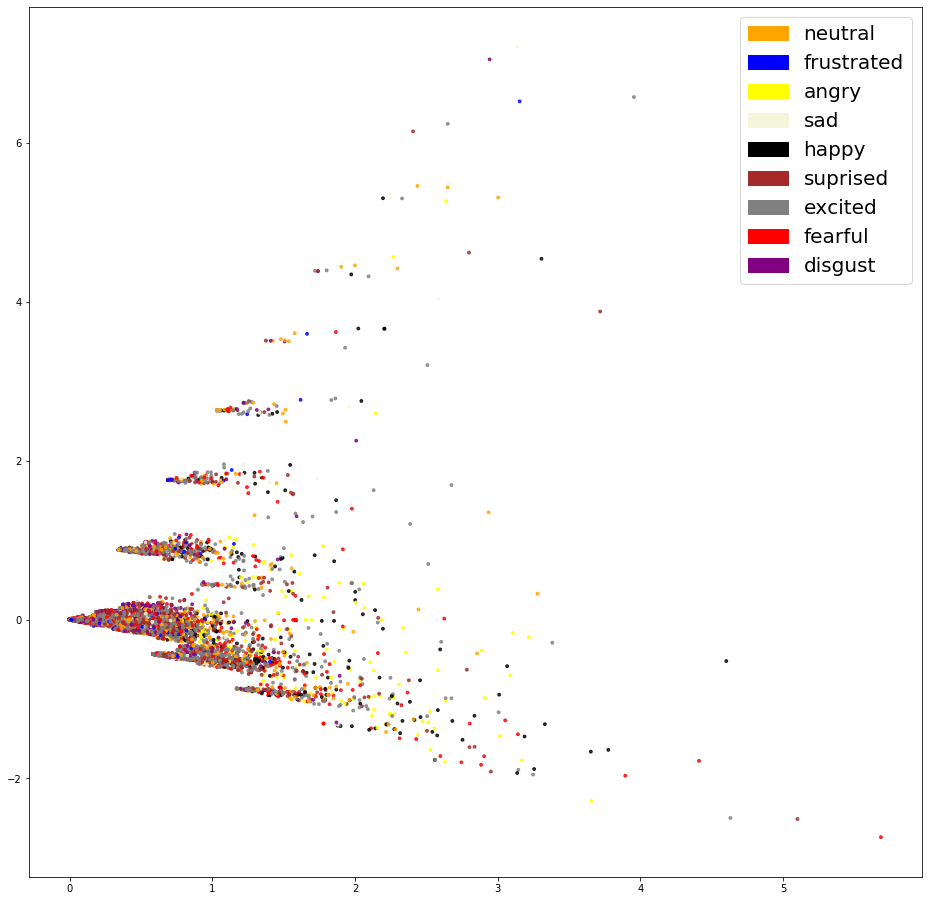

In [379]:
count = CountVectorizer()
xtrain_matrix = count.fit_transform(mergedIemocapMeld.Transcription)
ytrain_matrix = mergedIemocapMeld.DisEmotion

plot_LSA(xtrain_matrix,ytrain_matrix)

#### Os dados ainda estão muito juntos, vamos ver como ele se comporta com o tifidf vectorizer

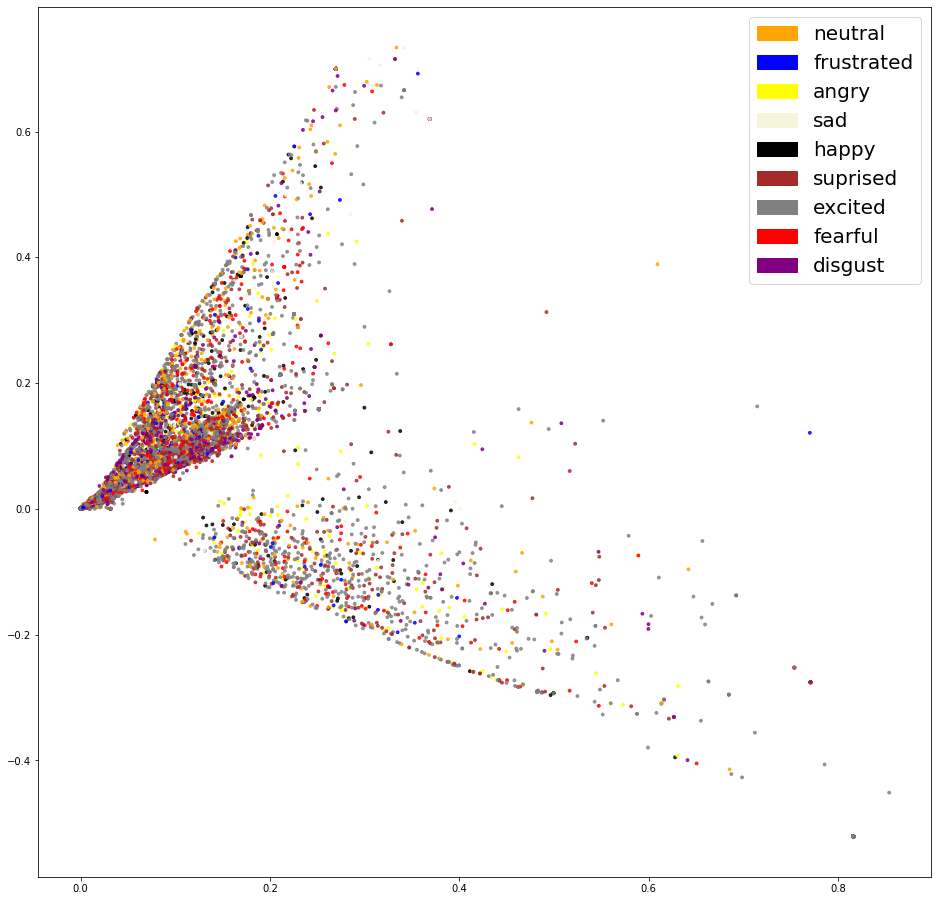

In [380]:
count = TfidfVectorizer()
xtrain_matrix = count.fit_transform(mergedIemocapMeld.Transcription)
ytrain_matrix = mergedIemocapMeld.DisEmotion

plot_LSA(xtrain_matrix,ytrain_matrix)

#### Ainda muito juntos, esse é um indicio que a classificação pode ter problemas, ou é a redução de dimensionalide que não está sendo bem executada.

#### Agora vamos ver como alguns classificadores se saem.

#### primeiro vamos testar uma suport vector machine com kernel linear, note que estamos usando o grid search cv para encontrar a melhor hiper parametrização. Vamos usar por enquanto count vectorizer.

In [381]:
xtrain, xtest, ytrain_right, ytest_right = train_test_split(mergedIemocapMeld.Transcription,mergedIemocapMeld.DisEmotion,random_state=7)

In [382]:
count = CountVectorizer(ngram_range=(1,2))
xtrain_matrix = count.fit_transform(xtrain)
xtest_matrix = count.transform(xtest)

In [383]:
dici = {"penalty":["l2"],"loss":["hinge","squared_hinge"]}

grid = GridSearchCV(LinearSVC(),param_grid=dici)

grid.fit(xtrain_matrix,ytrain_right)

grid.best_estimator_

/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [384]:
grid.best_score_

0.45658316067055943

#### Uma acuracia bastante baixa, vamos ver a matriz de confusão e outras métricas

In [385]:
model = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [386]:
model.fit(xtrain_matrix, ytrain_right)

output = model.predict(ytest_matrix)

#### Vamos plotar a matriz de confusão para ver como se sai

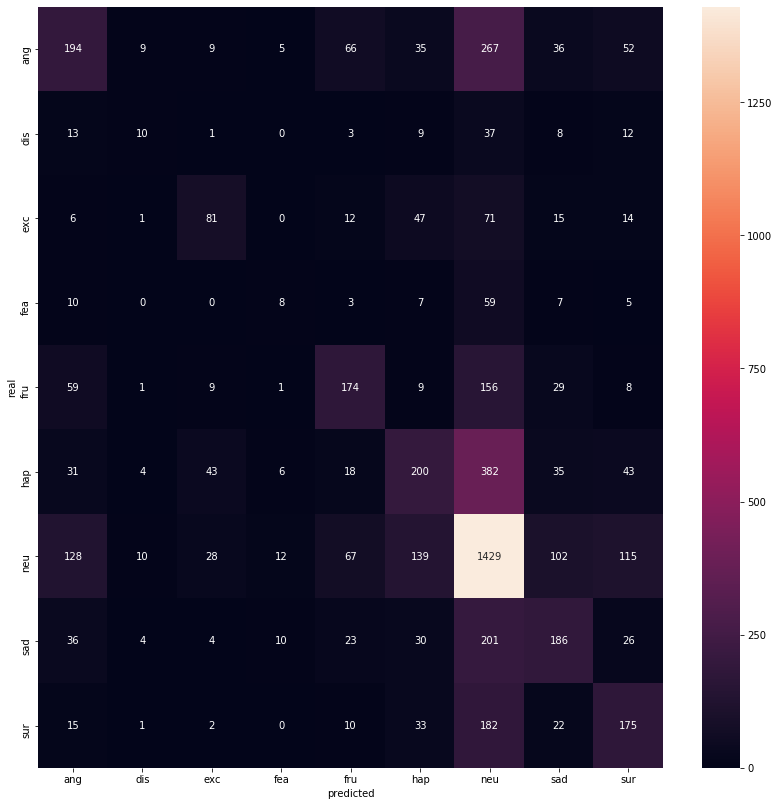

In [387]:
plt.figure(figsize=(14, 14)) 
cm = confusion_matrix(ytest_right,output)

cm = pd.DataFrame(cm,index = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"],columns = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"])

ax = sn.heatmap(cm,annot=True,fmt="d")

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("predicted")
plt.ylabel("real")

plt.show()

In [388]:
print(classification_report(ytest_right,output,target_names=["ang","dis","exc","fea","fru","hap","neu","sad","sur"]))

              precision    recall  f1-score   support

         ang       0.39      0.29      0.33       673
         dis       0.25      0.11      0.15        93
         exc       0.46      0.33      0.38       247
         fea       0.19      0.08      0.11        99
         fru       0.46      0.39      0.42       446
         hap       0.39      0.26      0.31       762
         neu       0.51      0.70      0.59      2030
         sad       0.42      0.36      0.39       520
         sur       0.39      0.40      0.39       440

    accuracy                           0.46      5310
   macro avg       0.39      0.32      0.34      5310
weighted avg       0.44      0.46      0.44      5310



#### Podemos ver que as predições estão bastante dispersas, vamos testar com outros modelos.

In [389]:
dici2 = {"solver":["newton-cg", "sag", "lbfgs"],"multi_class":["multinomial"]}

grid2 = GridSearchCV(LogisticRegression(),param_grid=dici2)

grid2.fit(xtrain_matrix,ytrain_right)

grid2.best_estimator_

/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Conve

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [390]:
grid2.best_score_

0.48508821498085014

#### Uma precisão maior que a SVM. Vamos ver as métricas para o modelo.

In [391]:
model2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

model2.fit(xtrain_matrix, ytrain_right)

output2 = model2.predict(xtest_matrix)

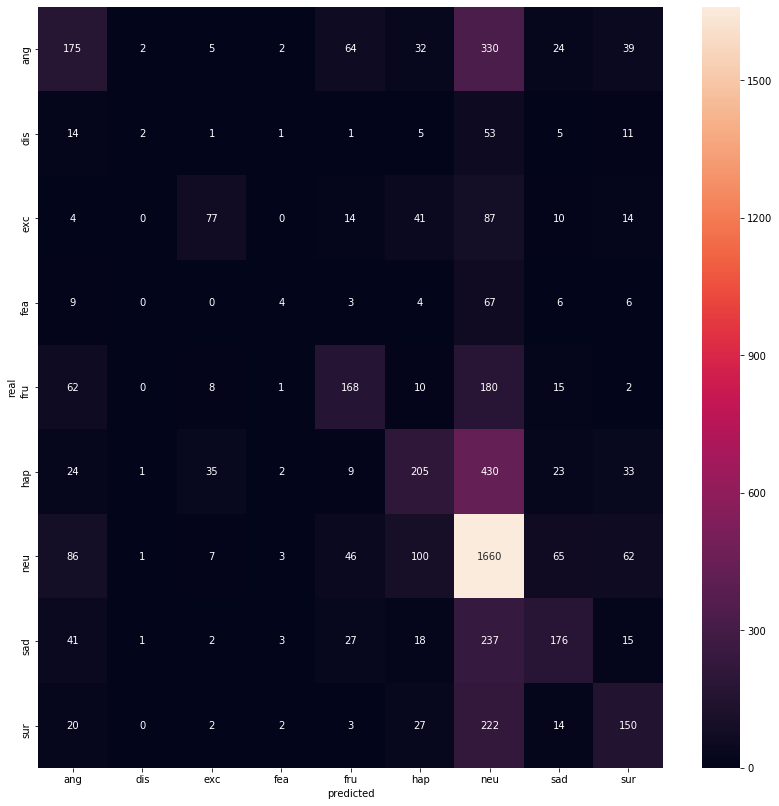

In [392]:
plt.figure(figsize=(14, 14)) 
cm = confusion_matrix(ytest_right,output2)

cm = pd.DataFrame(cm,index = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"],columns = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"])

ax = sn.heatmap(cm,annot=True,fmt="d")

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("predicted")
plt.ylabel("real")

plt.show()

In [393]:
print(classification_report(ytest_right,output2,target_names=["ang","dis","exc","fea","fru","hap","neu","sad","sur"]))

              precision    recall  f1-score   support

         ang       0.40      0.26      0.32       673
         dis       0.29      0.02      0.04        93
         exc       0.56      0.31      0.40       247
         fea       0.22      0.04      0.07        99
         fru       0.50      0.38      0.43       446
         hap       0.46      0.27      0.34       762
         neu       0.51      0.82      0.63      2030
         sad       0.52      0.34      0.41       520
         sur       0.45      0.34      0.39       440

    accuracy                           0.49      5310
   macro avg       0.44      0.31      0.34      5310
weighted avg       0.48      0.49      0.46      5310



#### Resultados bastante parecidos.

#### Outro classificador agora, dessa vez vamos testar o ridge classifier.

In [394]:
dici3 = {"solver":["cholesky", "lsqr", "sparse_cg", "sag", "saga"],"fit_intercept":[False]}

grid3 = GridSearchCV(RidgeClassifier(),param_grid=dici3)

grid3.fit(xtrain_matrix,ytrain_right)

grid3.best_estimator_

/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, normalize=False, random_state=None,
                solver='saga', tol=0.001)

In [395]:
grid3.best_score_

0.44465373265523955

#### Um resultado pior que os outros dois. Vamos ver as métricas.

In [396]:
model3 = RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, normalize=False, random_state=None,
                solver='saga', tol=0.001)
model3.fit(xtrain_matrix,ytrain_right)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, normalize=False, random_state=None,
                solver='saga', tol=0.001)

In [397]:
output3 = model3.predict(xtest_matrix)

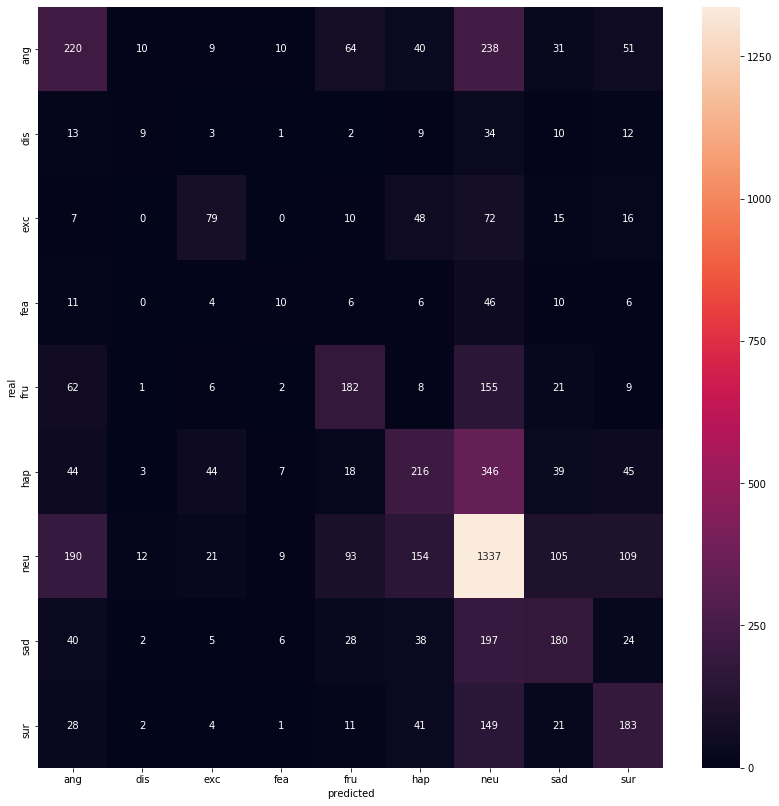

In [398]:
plt.figure(figsize=(14, 14)) 
cm = confusion_matrix(ytest_right,output3)

cm = pd.DataFrame(cm,index = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"],columns = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"])

ax = sn.heatmap(cm,annot=True,fmt="d")

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("predicted")
plt.ylabel("real")

plt.show()

In [399]:
print(classification_report(ytest_right,output3,target_names=["ang","dis","exc","fea","fru","hap","neu","sad","sur"]))

              precision    recall  f1-score   support

         ang       0.36      0.33      0.34       673
         dis       0.23      0.10      0.14        93
         exc       0.45      0.32      0.37       247
         fea       0.22      0.10      0.14        99
         fru       0.44      0.41      0.42       446
         hap       0.39      0.28      0.33       762
         neu       0.52      0.66      0.58      2030
         sad       0.42      0.35      0.38       520
         sur       0.40      0.42      0.41       440

    accuracy                           0.45      5310
   macro avg       0.38      0.33      0.35      5310
weighted avg       0.44      0.45      0.44      5310



###  Agora vamos tentar combinar os resultados dos 3 e usar um votting classifier para tentar predizer o resultado.

In [400]:
model4 = VotingClassifier([("LR",model),("SVM",model2),("RDG",model3)],voting="hard")

In [ ]:
model4.fit(xtrain_matrix,ytrain_right)

/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
output4 = model4.predict(xtest_matrix)

In [ ]:
print(classification_report(ytest_right,output4,target_names=["ang","dis","exc","fea","fru","hap","neu","sad","sur"]))

In [ ]:
plt.figure(figsize=(14, 14)) 
cm = confusion_matrix(ytest_right,output4)

cm = pd.DataFrame(cm,index = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"],columns = ["ang","dis","exc","fea","fru","hap","neu","sad","sur"])

ax = sn.heatmap(cm,annot=True,fmt="d")

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("predicted")
plt.ylabel("real")

plt.show()

### Ainda em torno dos 40%, deveriamos procurar modelos ou formas melhores de separar nossos dados.